In [ ]:

!pip install torch torchvision timm albumentations --quiet
!pip install torchmetrics --quiet
!pip install kornia --quiet
!pip install style-transfer-pytorch --quiet 
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import numpy as np
import random
from PIL import Image
import timm
import albumentations as A
import albumentations.pytorch
import kornia.augmentation as K
from torchmetrics import Accuracy
from copy import deepcopy
#TRAINING FOR RESNET->DO NOT RUN 

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


train_transform_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
])


from torchvision.transforms import InterpolationMode

train_transform_vit = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform_vit = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])


train_dataset_cifar = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform_cifar
)
test_dataset_cifar = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform_cifar
)


train_dataset_vit = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform_vit
)
test_dataset_vit = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform_vit
)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=64, shuffle=True, num_workers=2)
test_loader_cifar  = DataLoader(test_dataset_cifar, batch_size=64, shuffle=False, num_workers=2)

train_loader_vit = DataLoader(train_dataset_vit, batch_size=64, shuffle=True, num_workers=2)
test_loader_vit   = DataLoader(test_dataset_vit, batch_size=64, shuffle=False, num_workers=2)



class GrayscaleDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = TF.rgb_to_grayscale(img, num_output_channels=3) 
        return img, label

grayscale_test_loader = DataLoader(GrayscaleDataset(test_dataset_cifar), batch_size=64, shuffle=False)


class LocalityBiasDataset(Dataset):
    def __init__(self, dataset, mode="translate", shift_pixels=5, patch_size=8, occlude_size=16):
        self.dataset = dataset
        self.mode = mode
        self.shift = shift_pixels
        self.patch_size = patch_size
        self.occlude_size = occlude_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.mode == "translate":
          
            img = torch.roll(img, shifts=(self.shift, self.shift), dims=(1, 2))
        elif self.mode == "patch_shuffle":
            C, H, W = img.shape

            H = (H // self.patch_size) * self.patch_size
            W = (W // self.patch_size) * self.patch_size
            img = img[:, :H, :W]


            patches = img.view(
                C,
                H // self.patch_size,
                self.patch_size,
                W // self.patch_size,
                self.patch_size
            )  

            patches = patches.permute(1, 3, 0, 2, 4)  
            nH, nW = patches.shape[:2]
            patches = patches.reshape(-1, C, self.patch_size, self.patch_size)

   
            idxs = torch.randperm(patches.size(0))
            patches = patches[idxs]

        
            patches = patches.view(nH, nW, C, self.patch_size, self.patch_size)
            patches = patches.permute(2, 0, 3, 1, 4).reshape(C, H, W)
            img = patches
        elif self.mode == "occlude":
       
            C, H, W = img.shape
            x_start = (W - self.occlude_size) // 2
            y_start = (H - self.occlude_size) // 2
            img[:, y_start:y_start+self.occlude_size, x_start:x_start+self.occlude_size] = 0
        return img, label

patch_shuffle_loader = DataLoader(LocalityBiasDataset(test_dataset_cifar, mode="patch_shuffle"), batch_size=64, shuffle=False)


resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)
resnet_backbone = nn.Sequential(*list(resnet_model.children())[:-1]).to(device)  


vit_model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=10)
vit_model = vit_model.to(device)




def train_model(model, train_loader, test_loader, epochs=5, lr=1e-4, eval_every=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        if (epoch + 1) % eval_every == 0:
            model.eval()
            acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)
            with torch.no_grad():
                for imgs, labels in test_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    preds = model(imgs)
                    acc_metric.update(preds, labels)
            acc = acc_metric.compute().item()
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}, Test Acc: {acc:.4f}")
        else:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")

    return model




resnet_model = train_model(resnet_model, train_loader_cifar, test_loader_cifar, epochs=5)
vit_model = train_model(vit_model, train_loader_vit, test_loader_vit, epochs=5)



def evaluate_model(model, loader):
    from torchmetrics.classification import Accuracy
    model.eval()
    acc_metric =  Accuracy(task="multiclass", num_classes=10).to(device)
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            acc_metric.update(preds, labels)
    return acc_metric.compute().item()

print("Grayscale Test Accuracy (ResNet):", evaluate_model(resnet_model, grayscale_test_loader))
print("Patch Shuffle Test Accuracy (ResNet):", evaluate_model(resnet_model, patch_shuffle_loader))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 102.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement style-transfer-pytorch (from versions: none)
ERROR: No matching distribution found for style-transfer-pytorch
Using device: cuda


100%|██████████| 170M/170M [00:16<00:00, 10.7MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch [1/5] - Loss: 0.8926
Epoch [2/5] - Loss: 0.5053, Test Acc: 0.8347
Epoch [3/5] - Loss: 0.3778
Epoch [4/5] - Loss: 0.2976, Test Acc: 0.8540
Epoch [5/5] - Loss: 0.2445
Epoch [1/5] - Loss: 0.1506
Epoch [2/5] - Loss: 0.0675, Test Acc: 0.9610
Epoch [3/5] - Loss: 0.0526
Epoch [4/5] - Loss: 0.0422, Test Acc: 0.9640
Epoch [5/5] - Loss: 0.0383
Grayscale Test Accuracy (ResNet): 0.7524999976158142
Patch Shuffle Test Accuracy (ResNet): 0.2976999878883362


In [ ]:

!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

import clip
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])



cifar_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
cifar_test = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=clip_preprocess
)
cifar_test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)


cifar_classes = cifar_test.classes
print("CIFAR-10 classes:", cifar_classes)

prompts = [f"a photo of a {c}" for c in cifar_classes]
text_tokens = clip.tokenize(prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

def evaluate_clip_zero_shot(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarities = image_features @ text_features.T
            preds = similarities.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

clip_acc = evaluate_clip_zero_shot(cifar_test_loader)
print(f"CLIP Zero-Shot CIFAR-10 Accuracy: {clip_acc:.4f} ({clip_acc:.2%})")


resnet_model.eval()
def evaluate_resnet(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = resnet_model(imgs)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return correct / total

resnet_acc = evaluate_resnet(cifar_test_loader)
print(f"ResNet Supervised CIFAR-10 Accuracy: {resnet_acc:.4f} ({resnet_acc:.2%})")

print("\n--- Experiment 1 Results ---")
print(f"CLIP Zero-Shot Accuracy: {clip_acc:.2%}")
print(f"ResNet Supervised Accuracy: {resnet_acc:.2%}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 77.4MiB/s]


CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CLIP Zero-Shot CIFAR-10 Accuracy: 0.8874 (88.74%)
ResNet Supervised CIFAR-10 Accuracy: 0.1001 (10.01%)

--- Experiment 1 Results ---
CLIP Zero-Shot Accuracy: 88.74%
ResNet Supervised Accuracy: 10.01%


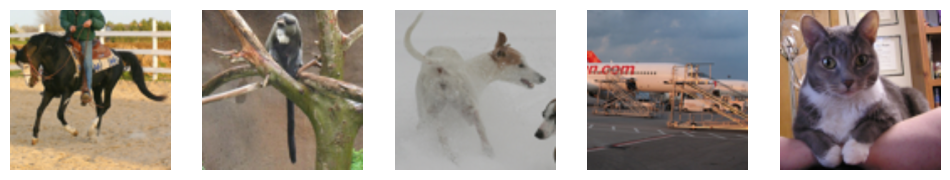

STL10 classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
CLIP Zero-Shot STL10 Accuracy: 0.9728 (97.28%)
ResNet (CIFAR-trained) on STL10 Accuracy: 0.1235 (12.35%)

--- Experiment 2 Results (Domain Shift) ---
CLIP Zero-Shot Accuracy: 97.28%
ResNet Domain-Shift Accuracy: 12.35%
[Image 0] True: horse, Pred: horse, Prompt: 'a photo of a horse'


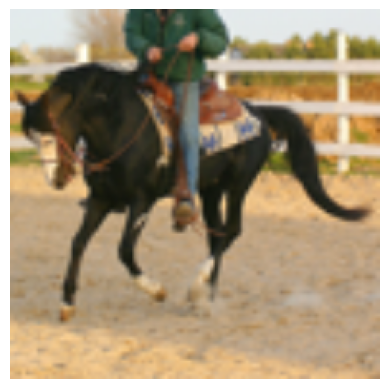

[Image 1] True: monkey, Pred: monkey, Prompt: 'a photo of a monkey'


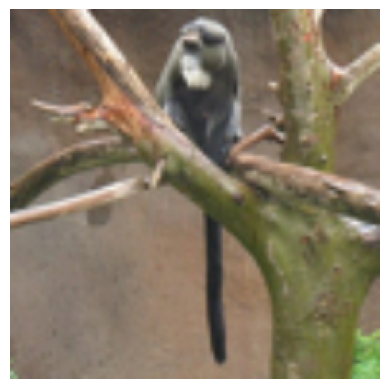

[Image 2] True: dog, Pred: dog, Prompt: 'a photo of a dog'


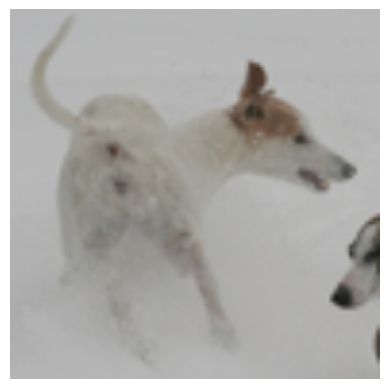

[Image 3] True: airplane, Pred: airplane, Prompt: 'a photo of a airplane'


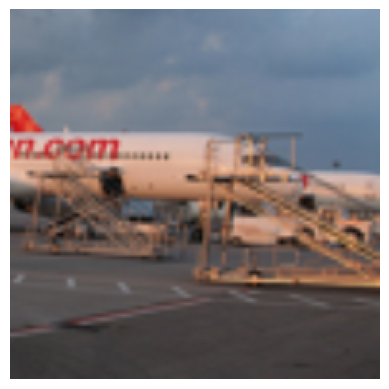

[Image 4] True: cat, Pred: cat, Prompt: 'a photo of a cat'


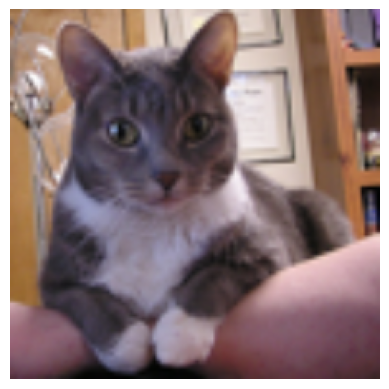

CLIP Zero-Shot STL10 Accuracy: 0.9728 (97.28%)


In [ ]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

=
stl_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

stl10_test = datasets.STL10(root='./data', split='test', download=True, transform=stl_transform)
stl10_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)

def show_images(loader, n=5):
    images, labels = next(iter(loader))
    images = images[:n]
    img = images * torch.tensor([0.2686,0.2613,0.2757]).view(3,1,1) + torch.tensor([0.4815,0.4578,0.4082]).view(3,1,1)
    img = img.clamp(0,1)
    img_np = img.permute(0,2,3,1).numpy()
    plt.figure(figsize=(12,4))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(img_np[i])
        plt.axis('off')
    plt.show()

show_images(stl10_loader, n=5)


stl10_classes = stl10_test.classes
print("STL10 classes:", stl10_classes[:10])

stl_prompts = [f"a photo of a {c}" for c in stl10_classes]
text_tokens_stl = clip.tokenize(stl_prompts).to(device)

with torch.no_grad():
    stl_text_features = clip_model.encode_text(text_tokens_stl)
    stl_text_features /= stl_text_features.norm(dim=-1, keepdim=True)
##ZERO SHOT EVAULATION

def evaluate_clip_stl(loader):
    correct, total = 0, 0
    clip_model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarities = image_features @ stl_text_features.T
            preds = similarities.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

clip_stl_acc = evaluate_clip_stl(stl10_loader)
print(f"CLIP Zero-Shot STL10 Accuracy: {clip_stl_acc:.4f} ({clip_stl_acc:.2%})")


resnet_model.eval()
def evaluate_resnet_stl(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = resnet_model(imgs)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return correct / total

resnet_stl_acc = evaluate_resnet_stl(stl10_loader)
print(f"ResNet (CIFAR-trained) on STL10 Accuracy: {resnet_stl_acc:.4f} ({resnet_stl_acc:.2%})")

print("\n--- Experiment 2 Results (Domain Shift) ---")
print(f"CLIP Zero-Shot Accuracy: {clip_stl_acc:.2%}")
print(f"ResNet Domain-Shift Accuracy: {resnet_stl_acc:.2%}")



def evaluate_clip_stl_verbose(loader, max_images=5):
    correct, total = 0, 0
    displayed = 0
    clip_model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarities = image_features @ stl_text_features.T
            preds = similarities.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for i in range(len(images)):
                if displayed >= max_images:
                    break
                pred_class = stl10_classes[preds[i]]
                true_class = stl10_classes[labels[i]]
                prompt_used = stl_prompts[preds[i]]
                print(f"[Image {batch_idx*loader.batch_size + i}] True: {true_class}, Pred: {pred_class}, Prompt: '{prompt_used}'")

                img = images[i].cpu() * torch.tensor([0.2686,0.2613,0.2757]).view(3,1,1) + torch.tensor([0.4815,0.4578,0.4082]).view(3,1,1)
                img = img.clamp(0,1).permute(1,2,0).numpy()
                plt.imshow(img)
                plt.axis('off')
                plt.show()

                displayed += 1

    acc = correct / total
    print(f"CLIP Zero-Shot STL10 Accuracy: {acc:.4f} ({acc:.2%})")
    return acc

clip_stl_acc_verbose = evaluate_clip_stl_verbose(stl10_loader, max_images=5)




--- Experiment 3: Prompt Engineering on CIFAR-10 ---
[Image 0] True: cat, Pred: ship, Prompt: 'ship'


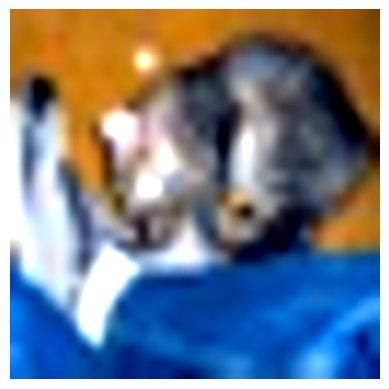

[Image 1] True: ship, Pred: ship, Prompt: 'ship'


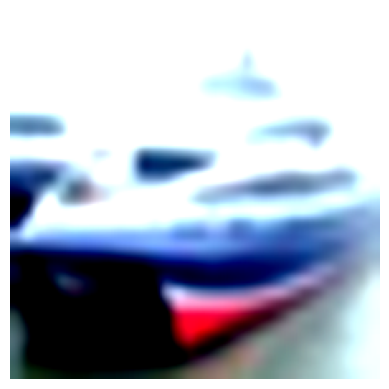

[Image 2] True: ship, Pred: ship, Prompt: 'ship'


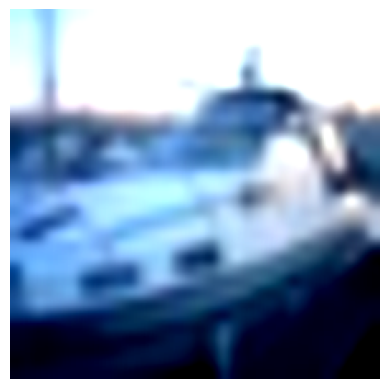

[Image 3] True: airplane, Pred: airplane, Prompt: 'airplane'


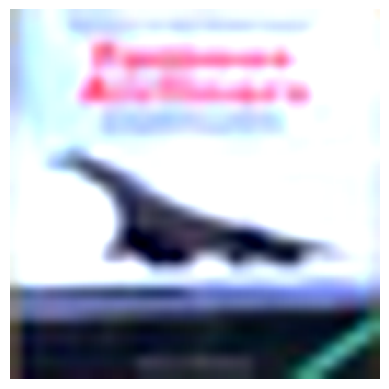

[Image 4] True: frog, Pred: frog, Prompt: 'frog'


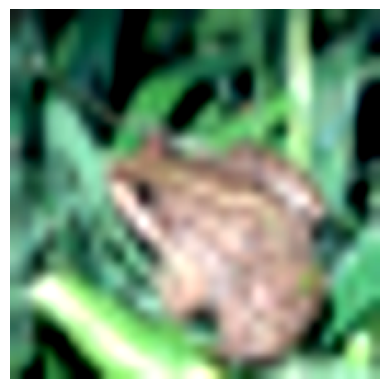

Template: '{c}' -> Accuracy: 0.8739 (87.39%)

[Image 0] True: cat, Pred: cat, Prompt: 'a photo of a cat'


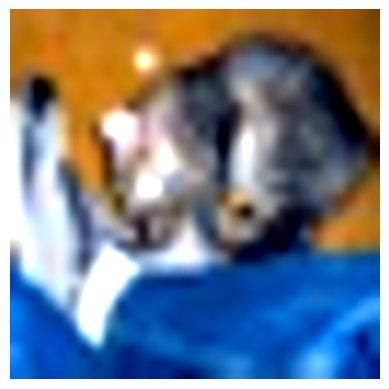

[Image 1] True: ship, Pred: ship, Prompt: 'a photo of a ship'


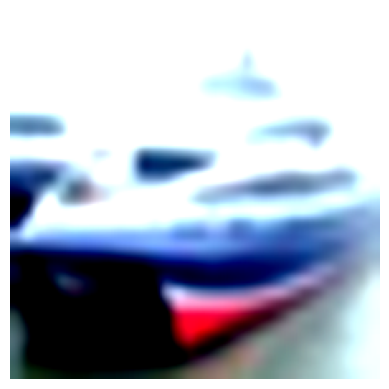

[Image 2] True: ship, Pred: ship, Prompt: 'a photo of a ship'


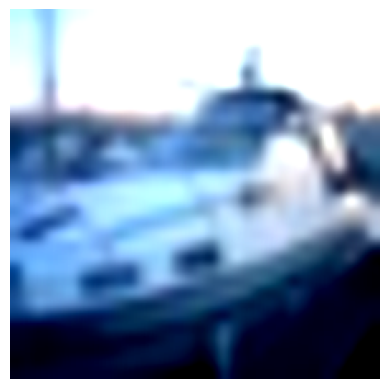

[Image 3] True: airplane, Pred: airplane, Prompt: 'a photo of a airplane'


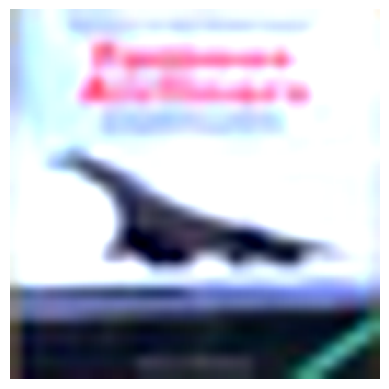

[Image 4] True: frog, Pred: frog, Prompt: 'a photo of a frog'


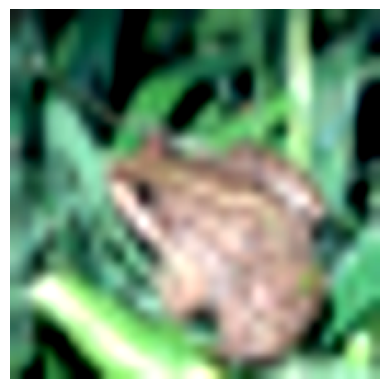

Template: 'a photo of a {c}' -> Accuracy: 0.8874 (88.74%)



[Image 0] True: cat, Pred: cat, Prompt: 'a photo of the cat'


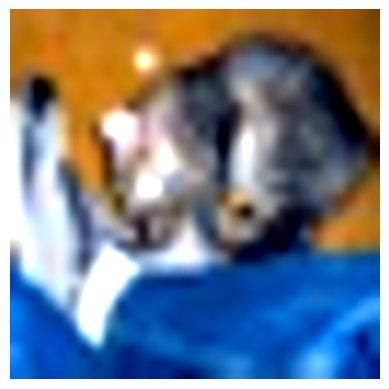

[Image 1] True: ship, Pred: ship, Prompt: 'a photo of the ship'


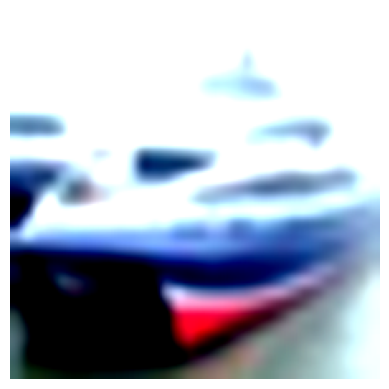

[Image 2] True: ship, Pred: ship, Prompt: 'a photo of the ship'


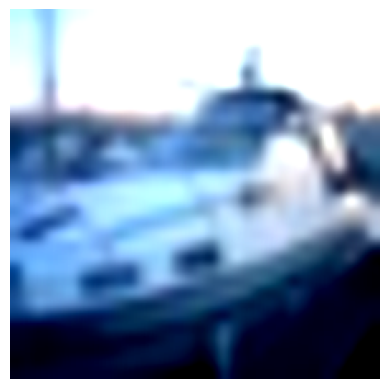

[Image 3] True: airplane, Pred: airplane, Prompt: 'a photo of the airplane'


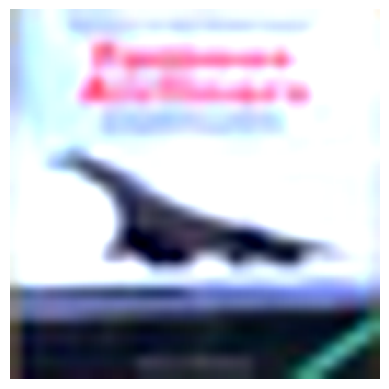

[Image 4] True: frog, Pred: frog, Prompt: 'a photo of the frog'


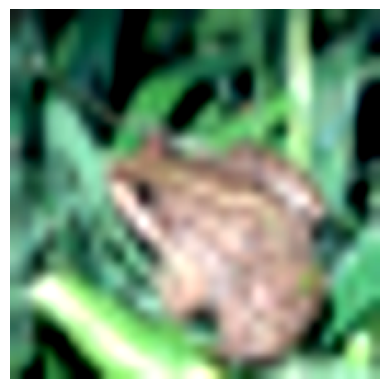

Template: 'a photo of the {c}' -> Accuracy: 0.8896 (88.96%)



[Image 0] True: cat, Pred: cat, Prompt: 'an image of a cat, cat'


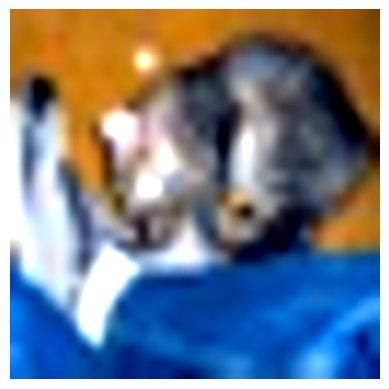

[Image 1] True: ship, Pred: ship, Prompt: 'an image of a ship, ship'


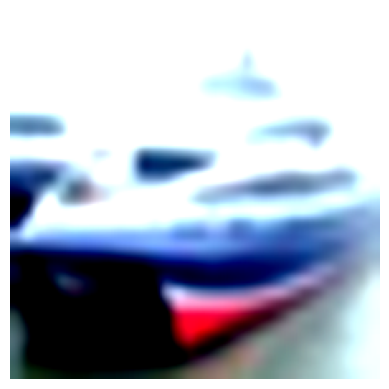

[Image 2] True: ship, Pred: ship, Prompt: 'an image of a ship, ship'


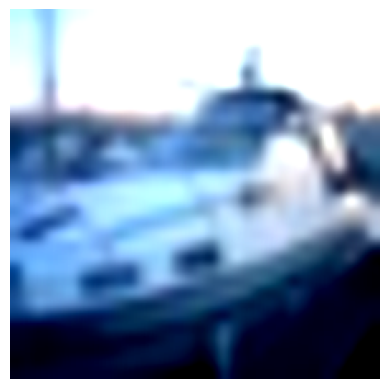

[Image 3] True: airplane, Pred: airplane, Prompt: 'an image of a airplane, airplane'


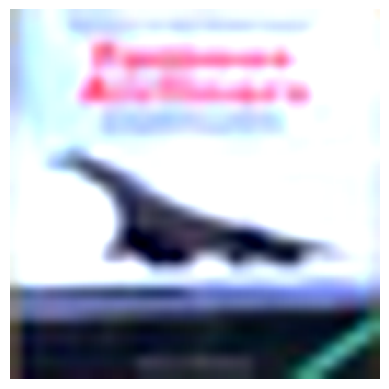

[Image 4] True: frog, Pred: frog, Prompt: 'an image of a frog, frog'


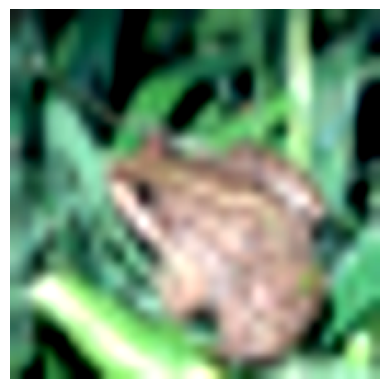

Template: 'an image of a {c}, {c}' -> Accuracy: 0.8854 (88.54%)



In [ ]:


# OROMPT TEMPLATES USED
prompt_templates = [
    "{c}",                          
    "a photo of a {c}",             
    "a photo of the {c}",           
    "an image of a {c}, {c}"        
]


cifar_classes = cifar_test.classes

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def evaluate_prompts_verbose(templates, loader, max_images=5):
    results = {}
    for template in templates:
        prompts = [template.format(c=cls) for cls in cifar_classes]
        text_tokens = clip.tokenize(prompts).to(device)
        with torch.no_grad():
            text_features = clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)

        correct, total = 0, 0
        displayed = 0  
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(loader):
                images, labels = images.to(device), labels.to(device)
                image_features = clip_model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                sims = image_features @ text_features.T
                preds = sims.argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                
                for i in range(len(images)):
                    if displayed >= max_images:
                        break
                    pred_class = cifar_classes[preds[i]]
                    true_class = cifar_classes[labels[i]]
                    prompt_used = prompts[preds[i]]
                    print(f"[Image {batch_idx*loader.batch_size + i}] True: {true_class}, Pred: {pred_class}, Prompt: '{prompt_used}'")

                    
                    img_np = images[i].cpu().permute(1,2,0).numpy()
                    img_np = (img_np * 0.5 + 0.5)  
                    plt.imshow(img_np)
                    plt.axis('off')
                    plt.show()

                    displayed += 1

        acc = correct / total
        results[template] = acc
        print(f"Template: '{template}' -> Accuracy: {acc:.4f} ({acc:.2%})\n")
    return results


print("\n--- Experiment 3: Prompt Engineering on CIFAR-10 ---")
prompt_results_verbose = evaluate_prompts_verbose(prompt_templates, cifar_test_loader, max_images=5)





In [ ]:


import random
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets

device = "cuda" if torch.cuda.is_available() else "cpu"

cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=clip_preprocess)

selected_indices = []
seen_classes = set()
for idx, (_, label) in enumerate(cifar_test):
    if label not in seen_classes:
        selected_indices.append(idx)
        seen_classes.add(label)
    if len(seen_classes) == 10:
        break

extra_indices = random.sample(range(len(cifar_test)), 10)
selected_indices.extend(extra_indices)

images = torch.stack([cifar_test[i][0] for i in selected_indices]).to(device)
image_labels = [cifar_test[i][1] for i in selected_indices]
image_classnames = [cifar_test.classes[l] for l in image_labels]

print("Selected image classes:", image_classnames)


with torch.no_grad():
    image_features = clip_model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)


cifar_classes = cifar_test.classes
text_prompts = [f"a photo of a {c}" for c in cifar_classes]

extra_prompts = [
    "a sketch of a dog",
    "a toy airplane",
    "a drawing of a horse",
    "a vehicle with four wheels",
    "a photo of a ship",
    "a wild animal in the forest",
    "a household cat",
    "a truck on the road",
    "a photo of a frog",
    "a photo of a deer"
]
text_prompts.extend(extra_prompts)
text_prompts = text_prompts[:20] 

print("Text prompts:", text_prompts)

text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


similarity = image_features @ text_features.T  
similarity_np = similarity.cpu().numpy()

df = pd.DataFrame(
    similarity_np,
    index=[f"Image_{i}_{cls}" for i, cls in enumerate(image_classnames)],
    columns=[f"Text_{i}_{txt}" for i, txt in enumerate(text_prompts)]
)

from IPython.display import display
display(df)


best_text_for_image = similarity.argmax(dim=1).cpu().tolist()
print("\nBest text for each image:")
for i, t_idx in enumerate(best_text_for_image):
    print(f"Image {i} ({image_classnames[i]}) -> {text_prompts[t_idx]}")

best_image_for_text = similarity.argmax(dim=0).cpu().tolist()
print("\nBest image for each text:")
for j, i_idx in enumerate(best_image_for_text):
    print(f"Text {j} ({text_prompts[j]}) -> Image {i_idx} ({image_classnames[i_idx]})")


Selected image classes: ['cat', 'ship', 'airplane', 'frog', 'automobile', 'truck', 'dog', 'horse', 'deer', 'bird', 'frog', 'deer', 'frog', 'truck', 'frog', 'deer', 'truck', 'horse', 'dog', 'automobile']
Text prompts: ['a photo of a airplane', 'a photo of a automobile', 'a photo of a bird', 'a photo of a cat', 'a photo of a deer', 'a photo of a dog', 'a photo of a frog', 'a photo of a horse', 'a photo of a ship', 'a photo of a truck', 'a sketch of a dog', 'a toy airplane', 'a drawing of a horse', 'a vehicle with four wheels', 'a photo of a ship', 'a wild animal in the forest', 'a household cat', 'a truck on the road', 'a photo of a frog', 'a photo of a deer']


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Text_0_a photo of a airplane  \
Image_0_cat                              0.183472   
Image_1_ship                             0.198975   
Image_2_airplane                         0.240234   
Image_3_frog                             0.179321   
Image_4_automobile                       0.187256   
Image_5_truck                            0.172974   
Image_6_dog                              0.179565   
Image_7_horse                            0.179810   
Image_8_deer                             0.203979   
Image_9_bird                             0.204346   
Image_10_frog                            0.214966   
Image_11_deer                            0.199829   
Image_12_frog                            0.188232   
Image_13_truck                           0.196899   
Image_14_frog                            0.187500   
Image_15_deer                            0.179810   
Image_16_truck                           0.200684   
Image_17_horse                           0.194336   
Image_18_dog                             0.194092   
Image_19_automobile                      0.184326   

                     Text_1_a photo of a automobile  Text_2_a photo of a bird  \
Image_0_cat                                0.191162                  0.199707   
Image_1_ship                               0.212280                  0.190430   
Image_2_airplane                           0.215820                  0.234985   
Image_3_frog                               0.211670                  0.237427   
Image_4_automobile                         0.265869                  0.191406   
Image_5_truck                              0.224609                  0.187744   
Image_6_dog                                0.199219                  0.200684   
Image_7_horse                              0.204346                  0.208984   
Image_8_deer                               0.197754                  0.221680   
Image_9_bird                               0.210449                  0.271240   
Image_10_frog                              0.219849                  0.260986   
Image_11_deer                              0.199463                  0.225220   
Image_12_frog                              0.209595                  0.243286   
Image_13_truck                             0.234009                  0.198486   
Image_14_frog                              0.213013                  0.225342   
Image_15_deer                              0.193604                  0.219116   
Image_16_truck                             0.253906                  0.210938   
Image_17_horse                             0.213989                  0.207153   
Image_18_dog                               0.204468                  0.207886   
Image_19_automobile                        0.250977                  0.191406   

                     Text_3_a photo of a cat  Text_4_a photo of a deer  \
Image_0_cat                         0.214600                  0.187866   
Image_1_ship                        0.185913                  0.168091   
Image_2_airplane                    0.191162                  0.171875   
Image_3_frog                        0.223389                  0.205078   
Image_4_automobile                  0.189209                  0.176636   
Image_5_truck                       0.189087                  0.190552   
Image_6_dog                         0.237671                  0.200439   
Image_7_horse                       0.212036                  0.198242   
Image_8_deer                        0.203613                  0.279297   
Image_9_bird                        0.220947                  0.224854   
Image_10_frog                       0.242065                  0.207642   
Image_11_deer                       0.204834                  0.214966   
Image_12_frog                       0.233154                  0.203613   
Image_13_truck                      0.197021                  0.191895   
Image_14_frog                       0.223755                  0.206909   
Image_15_deer        


Best text for each image:
Image 0 (cat) -> a photo of a cat
Image 1 (ship) -> a photo of a ship
Image 2 (airplane) -> a toy airplane
Image 3 (frog) -> a photo of a frog
Image 4 (automobile) -> a photo of a automobile
Image 5 (truck) -> a photo of a truck
Image 6 (dog) -> a photo of a dog
Image 7 (horse) -> a photo of a horse
Image 8 (deer) -> a photo of a deer
Image 9 (bird) -> a photo of a bird
Image 10 (frog) -> a photo of a frog
Image 11 (deer) -> a wild animal in the forest
Image 12 (frog) -> a photo of a frog
Image 13 (truck) -> a photo of a truck
Image 14 (frog) -> a photo of a frog
Image 15 (deer) -> a photo of a deer
Image 16 (truck) -> a photo of a automobile
Image 17 (horse) -> a photo of a horse
Image 18 (dog) -> a photo of a dog
Image 19 (automobile) -> a photo of a automobile

Best image for each text:
Text 0 (a photo of a airplane) -> Image 2 (airplane)
Text 1 (a photo of a automobile) -> Image 4 (automobile)
Text 2 (a photo of a bird) -> Image 9 (bird)
Text 3 (a photo o

Dataset sizes -> CIFAR: 100 Grayscale: 50 Sketch: 50


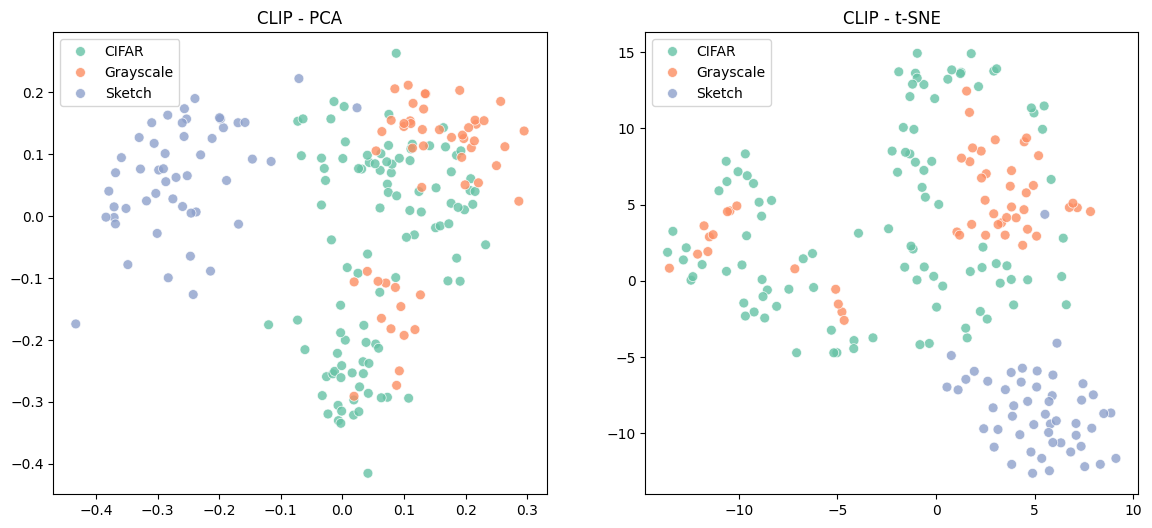

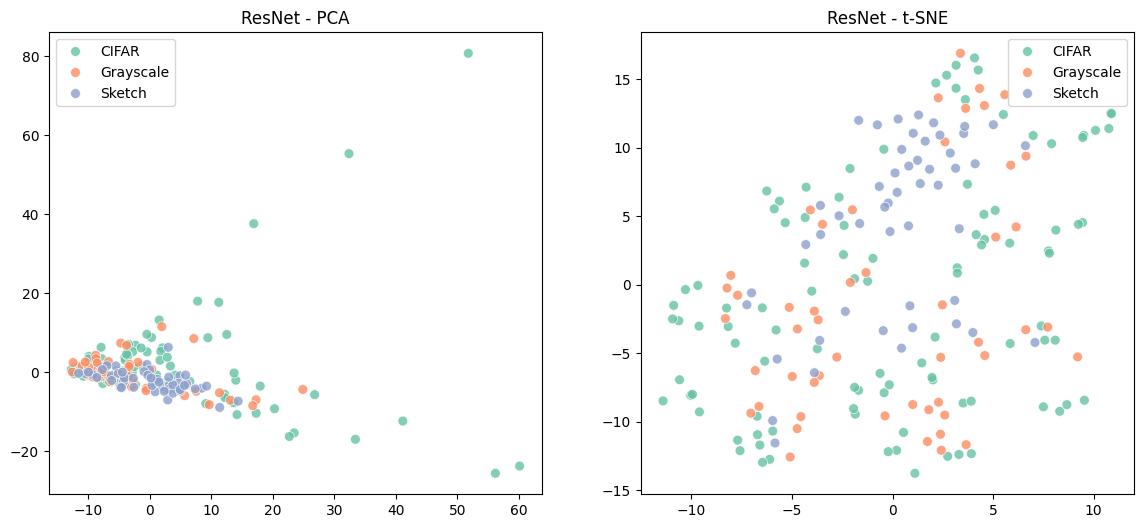


--- Clustering Quality (Silhouette Score) ---
CLIP Silhouette (class):   0.0175
ResNet Silhouette (class): 0.0456
CLIP Silhouette (domain):  0.0823
ResNet Silhouette (domain):-0.0603


In [ ]:


import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"

num_cifar = 100
cifar_indices = random.sample(range(len(test_dataset_cifar)), num_cifar)
cifar_imgs = torch.stack([test_dataset_cifar[i][0] for i in cifar_indices])
cifar_labels = [test_dataset_cifar[i][1] for i in cifar_indices]
cifar_classes = test_dataset_cifar.classes

num_gray = 50
gray_indices = random.sample(range(len(test_dataset_cifar)), num_gray)
gray_imgs = []
gray_labels = []
for i in gray_indices:
    img, label = test_dataset_cifar[i]
    img = TF.rgb_to_grayscale(img, num_output_channels=3)  
    gray_imgs.append(img)
    gray_labels.append(label)
gray_imgs = torch.stack(gray_imgs)

num_sketch = 50
sketch_imgs = []
sketch_labels = []
for i in random.sample(range(len(test_dataset_cifar)), num_sketch):
    img, label = test_dataset_cifar[i]
    C, H, W = img.shape
    patch_size = 8
    H = (H // patch_size) * patch_size
    W = (W // patch_size) * patch_size
    img = img[:, :H, :W]
    patches = img.view(C, H//patch_size, patch_size, W//patch_size, patch_size)
    patches = patches.permute(1, 3, 0, 2, 4).reshape(-1, C, patch_size, patch_size)
    patches = patches[torch.randperm(patches.size(0))]
    patches = patches.view(H//patch_size, W//patch_size, C, patch_size, patch_size)
    patches = patches.permute(2, 0, 3, 1, 4).reshape(C, H, W)
    sketch_imgs.append(patches)
    sketch_labels.append(label)
sketch_imgs = torch.stack(sketch_imgs)


all_images = torch.cat([cifar_imgs, gray_imgs, sketch_imgs], dim=0).to(device)
all_labels = cifar_labels + gray_labels + sketch_labels
all_domains = (["CIFAR"] * num_cifar) + (["Grayscale"] * num_gray) + (["Sketch"] * num_sketch)

print("Dataset sizes -> CIFAR:", len(cifar_imgs), "Grayscale:", len(gray_imgs), "Sketch:", len(sketch_imgs))


clip_model.eval()
resnet_model.eval()

clip_features = []
resnet_features = []

with torch.no_grad():
    for img in all_images:
        img_in = clip_preprocess(TF.to_pil_image(img.cpu())).unsqueeze(0).to(device)
        clip_feat = clip_model.encode_image(img_in)
        clip_feat = clip_feat / clip_feat.norm(dim=-1, keepdim=True)
        clip_features.append(clip_feat.squeeze(0).cpu().numpy())

        resnet_in = img.unsqueeze(0).to(device)
        res_feat = resnet_backbone(resnet_in)
        res_feat = res_feat.flatten(1) 
        resnet_features.append(res_feat.squeeze(0).cpu().numpy())

clip_features = np.array(clip_features)
resnet_features = np.array(resnet_features)


def reduce_and_plot(features, labels, domains, title):
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(features)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_res = tsne.fit_transform(features)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=domains,
                    palette="Set2", ax=axes[0], s=50, alpha=0.8)
    axes[0].set_title(f"{title} - PCA")

    sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=domains,
                    palette="Set2", ax=axes[1], s=50, alpha=0.8)
    axes[1].set_title(f"{title} - t-SNE")

    plt.show()

reduce_and_plot(clip_features, all_labels, all_domains, "CLIP")
reduce_and_plot(resnet_features, all_labels, all_domains, "ResNet")


domain_to_idx = {d: i for i, d in enumerate(set(all_domains))}
all_domains_int = [domain_to_idx[d] for d in all_domains]

clip_sil_class = silhouette_score(clip_features, all_labels)
resnet_sil_class = silhouette_score(resnet_features, all_labels)

clip_sil_domain = silhouette_score(clip_features, all_domains_int)
resnet_sil_domain = silhouette_score(resnet_features, all_domains_int)

print("\n--- Clustering Quality (Silhouette Score) ---")
print(f"CLIP Silhouette (class):   {clip_sil_class:.4f}")
print(f"ResNet Silhouette (class): {resnet_sil_class:.4f}")
print(f"CLIP Silhouette (domain):  {clip_sil_domain:.4f}")
print(f"ResNet Silhouette (domain):{resnet_sil_domain:.4f}")


Using device: cuda


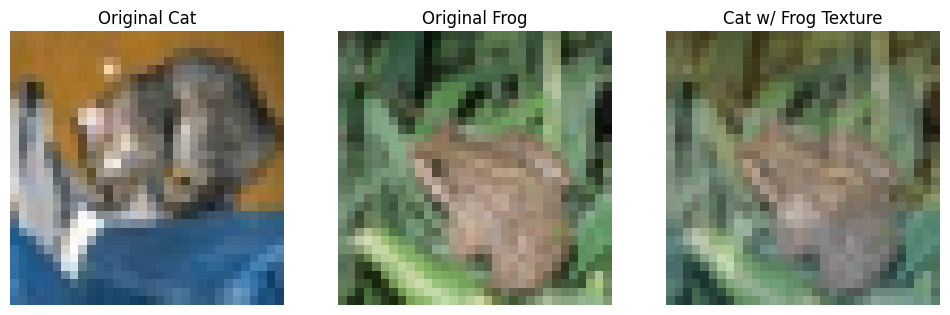


--- CLIP Shape vs Texture Bias ---
                  Image           Text Prompt  Similarity
0                   Cat      a photo of a cat    0.214478
1                   Cat     a photo of a frog    0.191406
2                   Cat      a photo of a dog    0.207764
3                   Cat  a photo of an animal    0.202393
4                  Frog      a photo of a cat    0.223389
5                  Frog     a photo of a frog    0.290771
6                  Frog      a photo of a dog    0.223145
7                  Frog  a photo of an animal    0.258057
8   Cat w/ Frog Texture      a photo of a cat    0.230225
9   Cat w/ Frog Texture     a photo of a frog    0.266602
10  Cat w/ Frog Texture      a photo of a dog    0.221924
11  Cat w/ Frog Texture  a photo of an animal    0.238647


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [ ]:

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
from torchvision import datasets, transforms


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

transform = transforms.Compose([transforms.ToTensor()])
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


cat_idx = next(i for i, (_, y) in enumerate(test_dataset_cifar)
               if y == test_dataset_cifar.class_to_idx["cat"])
cat_img, _ = test_dataset_cifar[cat_idx]

frog_idx = next(i for i, (_, y) in enumerate(test_dataset_cifar)
                if y == test_dataset_cifar.class_to_idx["frog"])
frog_img, _ = test_dataset_cifar[frog_idx]

cat_pil = T.ToPILImage()(cat_img)
frog_pil = T.ToPILImage()(frog_img)

def blend_images(content_pil, style_pil, alpha=0.5):
    """
    Simple blend: alpha*style + (1-alpha)*content
    """
    content = T.ToTensor()(content_pil)
    style = T.ToTensor()(style_pil)
    blended = (1-alpha)*content + alpha*style
    blended = blended.clamp(0,1)
    return T.ToPILImage()(blended)

cat_with_frog_texture = blend_images(cat_pil, frog_pil, alpha=0.7)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(cat_pil); axs[0].set_title("Original Cat"); axs[0].axis("off")
axs[1].imshow(frog_pil); axs[1].set_title("Original Frog"); axs[1].axis("off")
axs[2].imshow(cat_with_frog_texture); axs[2].set_title("Cat w/ Frog Texture"); axs[2].axis("off")
plt.show()


text_prompts = [
    "a photo of a cat",
    "a photo of a frog",
    "a photo of a dog",
    "a photo of an animal"
]

text_tokens = clip.tokenize(text_prompts).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

def get_clip_embedding(img_pil):
    img_in = clip_preprocess(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_in)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
    return img_feat

cat_feat = get_clip_embedding(cat_pil)
frog_feat = get_clip_embedding(frog_pil)
conflict_feat = get_clip_embedding(cat_with_frog_texture)

def compute_sim_table(img_name, img_feat, text_features, text_prompts):
    sims = (img_feat @ text_features.T).squeeze(0).cpu().numpy()
    return pd.DataFrame({
        "Image": [img_name]*len(text_prompts),
        "Text Prompt": text_prompts,
        "Similarity": sims
    })

sim_cat = compute_sim_table("Cat", cat_feat, text_features, text_prompts)
sim_frog = compute_sim_table("Frog", frog_feat, text_features, text_prompts)
sim_conflict = compute_sim_table("Cat w/ Frog Texture", conflict_feat, text_features, text_prompts)

results_table = pd.concat([sim_cat, sim_frog, sim_conflict], ignore_index=True)

print("\n--- CLIP Shape vs Texture Bias ---")
print(results_table)
